# [hotsline](https://github.com/AntoineGrimaldi/hotsline) algorithm to replicate results from [this paper](https://www.techrxiv.org/articles/preprint/A_robust_event-driven_approach_to_always-on_object_recognition/18003077/1)
## Load events of the POKER_DVS dataset with [Tonic](https://tonic.readthedocs.io/en/latest/index.html)

/home/antoine/homhots/hotsline/hots
 Tonic version installed -> 1.0.15
number of samples in the trainset: 48
----------------------------------------
number of samples in each class for the trainset: [12. 12. 12. 12.]
----------------------------------------
number of samples in the dataset: 48


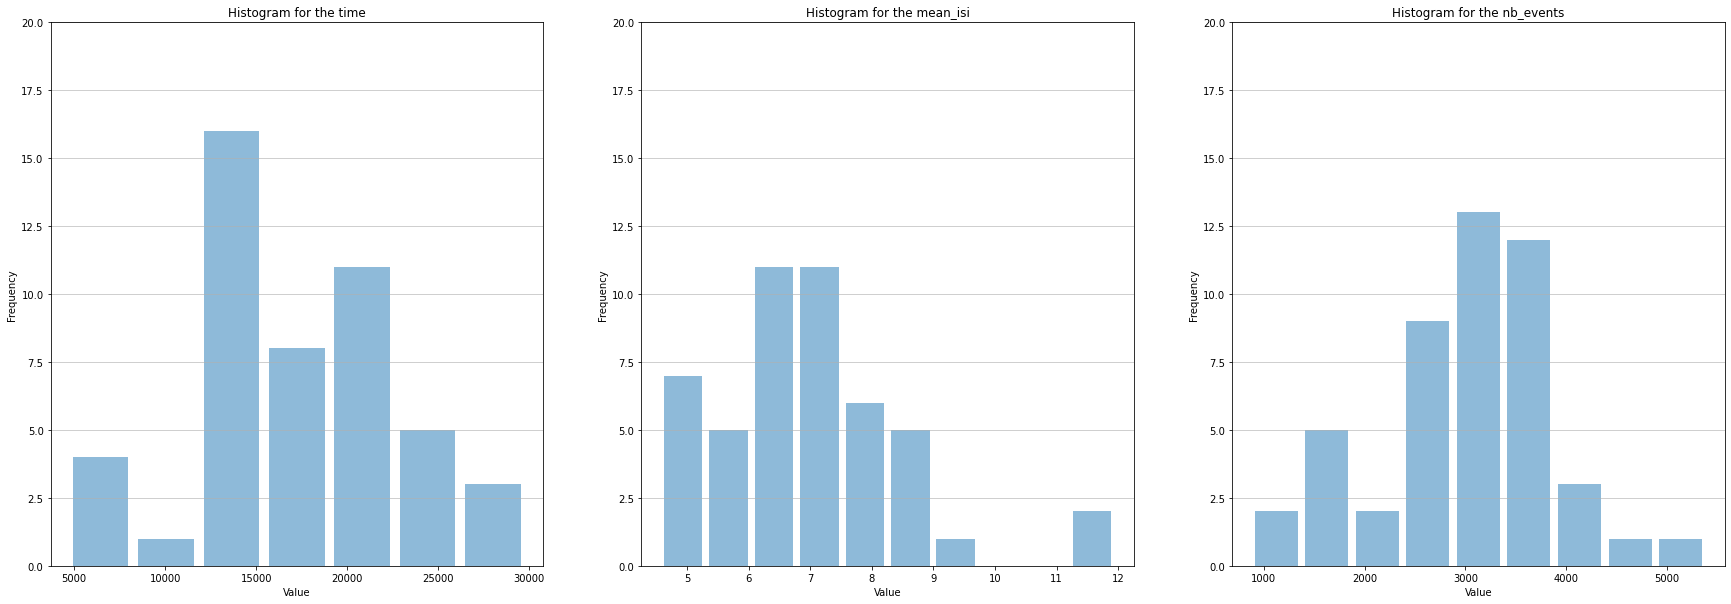

In [22]:
import tonic, torch, os
%cd ../hots
from utils import get_loader, get_dataset_info, HOTS_Dataset, make_histogram_classification
from network import network
from timesurface import timesurface

print(f' Tonic version installed -> {tonic.__version__}')

transform = tonic.transforms.NumpyAsType(int)
dataset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=transform)
loader = get_loader(dataset)
get_dataset_info(dataset, properties = ['time', 'mean_isi', 'nb_events']);
print(f'number of samples in the dataset: {len(loader)}')

## Parameter tuning with histogram classification

In [23]:
import matplotlib.pyplot as plt

def plot_accuracy(scores, parameters, ind_param):
    paramlist = ['number of layers', 'R', 'tau', 'number of neurons']
    fig, ax = plt.subplots(figsize=(10,6))
    score_previous = 0
    for ind in range(len(scores)):
        score, tau = scores[ind], parameters[ind][ind_param]
        ax.plot(tau, score, '*', color='blue')
        ax.set_xlabel(paramlist[ind_param])
        ax.set_ylabel('accuracy')
        if score>score_previous:
            score_previous=score
            parameters_previous=parameters[ind]
    print(score_previous, parameters_previous)
    
def plot_accuracy_multi_param(scores, parameters):
    fig = plt.figure(figsize=(30,10))
    sub1 = fig.add_subplot(1,3,1, projection="3d")
    sub2 = fig.add_subplot(1,3,2, projection="3d")
    sub3 = fig.add_subplot(1,3,3, projection="3d")
    score_previous = 0
    colormap = plt.cm.get_cmap('summer_r', 10);
    for ind in range(len(scores)):
        score, lay, n_neuron, R = scores[ind], parameters[ind][0], parameters[ind][3], parameters[ind][1]
        sub1.scatter(n_neuron, lay, score, color=colormap(R/4), alpha=0.5)
        sub2.scatter(R, lay, score, color=colormap(n_neuron/16), alpha=0.5)
        sub3.scatter(n_neuron, R, score, color=colormap(lay/4), alpha=0.5)
        sub1.set_xlabel('neuron number')
        sub2.set_xlabel('R')
        sub3.set_xlabel('neuron number')
        sub1.set_ylabel('layer number')
        sub2.set_ylabel('layer number')
        sub3.set_ylabel('R')
        #sub1.view_init(10,-40)

In [24]:
name = 'homeohots'
homeo = True
timestr = '2022-04-22'
dataset_name = 'poker'

Rz = [2, 4]
N_neuronz = [4, 8]
tauz = [.7e3*2, .7e3*4]
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]

hots = network(name, dataset_name, timestr, dataset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

In [21]:
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
path = '../Records/networks/'+hots.name+'.pkl'
print(path)
if not os.path.exists(path):
    hots.clustering(loader, dataset.ordering, filtering_threshold)
hots.plotlayers();

../Records/networks/2022-04-22_poker_homeohots_True_[4, 8]_[1400.0, 2800.0]_[2, 4].pkl


  5%|███████████▋                                                                                                                                                                                                                              | 1/20 [00:16<05:20, 16.86s/it]


KeyboardInterrupt: 

In [16]:
loader = get_loader(dataset, kfold = None, shuffle=True)
num_sample_train = len(dataset)
hots.coding(loader, dataset.ordering, dataset.classes, filtering_threshold, training=True)

this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[4, 8]_[1400.0, 1400.0]_[2, 4]_48_(None, None)/


In [17]:
dataset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=transform)
num_sample_test = len(dataset)
loader = get_loader(dataset, kfold = None, shuffle=True)
hots.coding(loader, dataset.ordering, dataset.classes, filtering_threshold, training=False)

this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[4, 8]_[1400.0, 1400.0]_[2, 4]_20_(None, None)/


In [18]:
from utils import make_histogram_classification, HOTS_Dataset

jitter = (None, None)

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

testset = HOTS_Dataset(test_path, dataset.sensor_size, transform=tonic.transforms.NumpyAsType(int))
trainset = HOTS_Dataset(train_path, dataset.sensor_size, transform=tonic.transforms.NumpyAsType(int))

In [19]:
score = make_histogram_classification(trainset, testset, N_neuronz[-1])
print(f' Accuracy: {score*100}%')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 781.35it/s]

 Accuracy: 90.0%


## Rough parameters trial

In [12]:
import matplotlib.pyplot as plt
import copy

def plot_accuracy(scores, parameters, param_to_plot):
    paramlist = ['number of layers', 'R', 'tau', 'number of neurons']
    fig, ax = plt.subplots(figsize=(10,6))
    score_previous = 0
    for ind in range(len(scores)):
        score, tau, n_layer, R, n_neurons = scores[ind], parameters[ind][2], parameters[ind][0], parameters[ind][1], parameters[ind][3]
        if param_to_plot=='tau':
            x = copy.copy(tau)
        elif param_to_plot=='R':
            x = copy.copy(R)
        elif param_to_plot=='neuron':
            x = copy.copy(n_neurons)
        elif param_to_plot=='layer':
            x = copy.copy(n_layer)
        
        ax.plot(x, score, '*', color='blue')
        if n_layer==2 and R==4 and n_neurons==4:
            ax.plot(x, score, '*', color='red')
        if n_layer==2 and R==4 and n_neurons==8:
            ax.plot(x, score, '*', color='green')
        if n_layer==2 and R==4 and n_neurons==16:
            ax.plot(x, score, '*', color='orange')

        ax.set_xlabel(param_to_plot)
        ax.set_ylabel('accuracy')
        if score>score_previous:
            score_previous=score
            parameters_previous=parameters[ind]
    print(score_previous, parameters_previous)
    
def plot_accuracy_multi_param(scores, parameters):
    fig = plt.figure(figsize=(30,10))
    sub1 = fig.add_subplot(1,3,1, projection="3d")
    sub2 = fig.add_subplot(1,3,2, projection="3d")
    sub3 = fig.add_subplot(1,3,3, projection="3d")
    score_previous = 0
    colormap = plt.cm.get_cmap('summer_r', 10);
    for ind in range(len(scores)):
        score, lay, n_neuron, R = scores[ind], parameters[ind][0], parameters[ind][3], parameters[ind][1]
        sub1.scatter(n_neuron, lay, score, color=colormap(R/4), alpha=0.5)
        sub2.scatter(R, lay, score, color=colormap(n_neuron/16), alpha=0.5)
        sub3.scatter(n_neuron, R, score, color=colormap(lay/4), alpha=0.5)
        sub1.set_xlabel('neuron number')
        sub2.set_xlabel('R')
        sub3.set_xlabel('neuron number')
        sub1.set_ylabel('layer number')
        sub2.set_ylabel('layer number')
        sub3.set_ylabel('R')
        #sub1.view_init(10,-40)

0.95 [2, 2, 700.0, 8]
0.95 [2, 2, 700.0, 8]
0.95 [2, 2, 700.0, 8]
0.95 [2, 2, 700.0, 8]


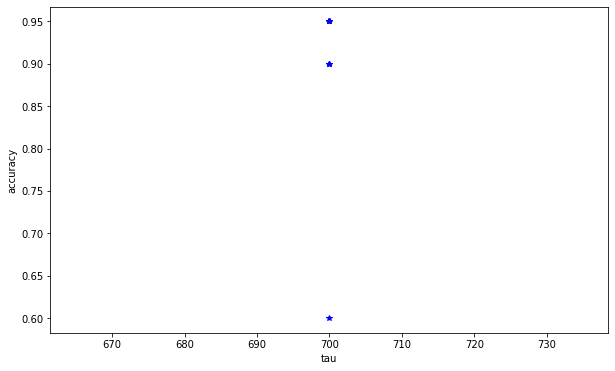

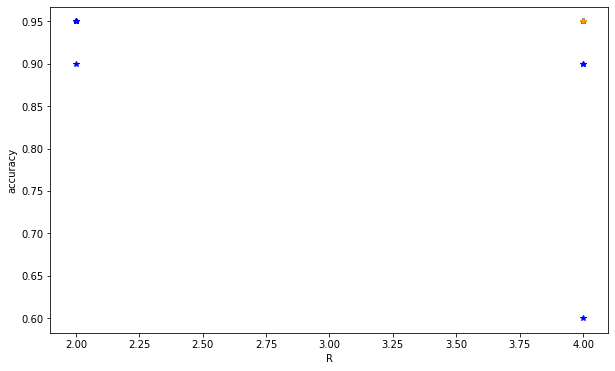

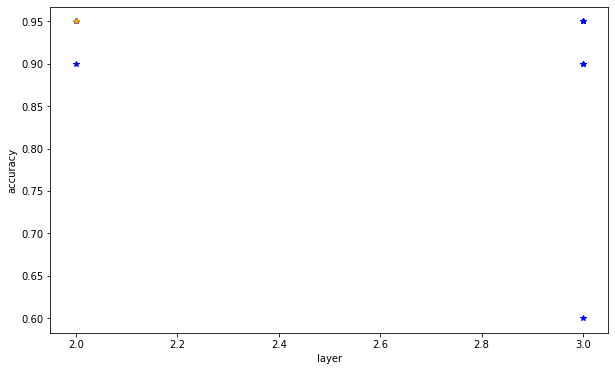

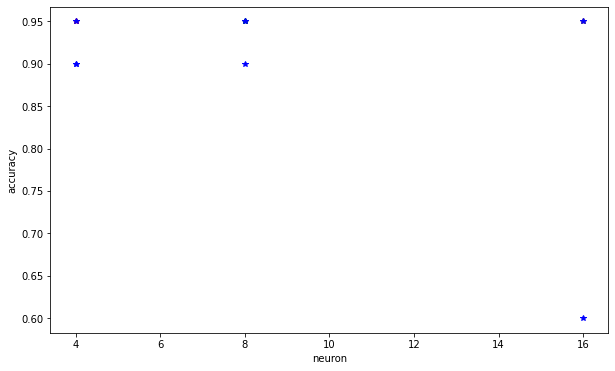

In [13]:
plot_accuracy(scores, parameters, 'tau')
plot_accuracy(scores, parameters, 'R')
plot_accuracy(scores, parameters, 'layer')
plot_accuracy(scores, parameters, 'neuron')

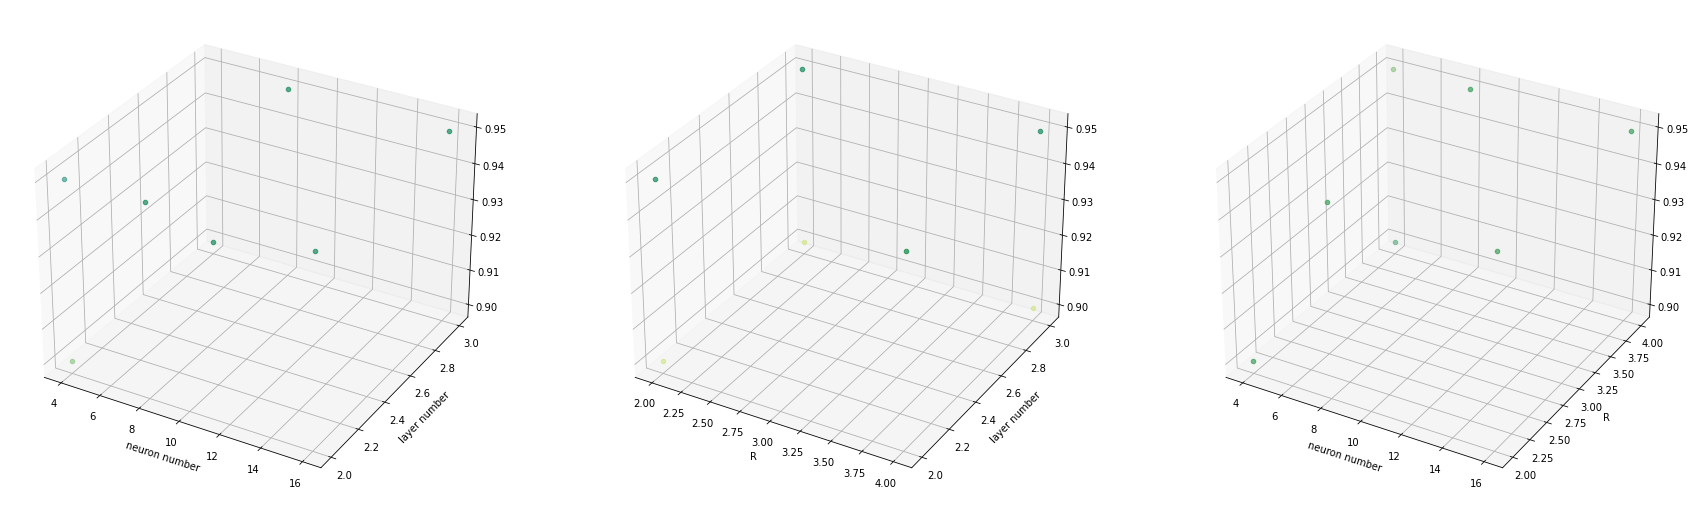

In [12]:
plot_accuracy_multi_param(scores, parameters)

In [25]:
def poker_parameter_testing(R_first,N_layers,n_first,tau_first):
    transform = tonic.transforms.NumpyAsType(int)
    trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=transform)
    testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=transform)

    name = 'homeohots'
    homeo = True
    timestr = '2022-04-22'
    dataset_name = 'poker'

    parameters = []
    scores = []

    for lay in N_layers:
        for R in R_first:
            for tau in tau_first:
                for N_neuron in n_first:
                    Rz = [R*2**Nl for Nl in range(lay)]
                    N_neuronz = [N_neuron*2**Nl for Nl in range(lay)]
                    N_pola = N_neuronz.copy()
                    N_pola.insert(0,2)
                    tauz = [tau*N_pola[Nl] for Nl in range(lay)]
                    hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)
                    print(hots.name)
                    filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
                    #clustering
                    loader = get_loader(trainset)
                    hots.clustering(loader, trainset.ordering, filtering_threshold)
                    #training
                    loader = get_loader(trainset)
                    num_sample_train = len(loader)
                    hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=True)
                    #testing
                    loader = get_loader(testset)
                    num_sample_test = len(loader)
                    hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=False)
                    jitter = (None, None)

                    train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
                    test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

                    testset_output = HOTS_Dataset(test_path, trainset.sensor_size, transform=tonic.transforms.NumpyAsType(int))
                    trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, transform=tonic.transforms.NumpyAsType(int))

                    score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1]) 
                    print(f' Accuracy: {score*100}%')

                    parameters.append([lay, R, tau, N_neuron])
                    scores.append(score)
    return scores, parameters

In [26]:
R_first =  [2,4]
N_layers = [2,3]
n_first = [4,8,16]
tau_first = [.7e3]

scores, parameters = poker_parameter_testing(R_first,N_layers,n_first,tau_first)

2022-04-22_poker_homeohots_True_[4, 8]_[1400.0, 1400.0]_[2, 4]
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[4, 8]_[1400.0, 1400.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[4, 8]_[1400.0, 1400.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 668.04it/s]


 Accuracy: 90.0%
2022-04-22_poker_homeohots_True_[8, 16]_[1400.0, 2800.0]_[2, 4]
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[8, 16]_[1400.0, 2800.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[8, 16]_[1400.0, 2800.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 498.27it/s]


 Accuracy: 95.0%
2022-04-22_poker_homeohots_True_[16, 32]_[1400.0, 5600.0]_[2, 4]
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[1400.0, 5600.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[1400.0, 5600.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 648.21it/s]


 Accuracy: 95.0%
2022-04-22_poker_homeohots_True_[4, 8]_[1400.0, 1400.0]_[4, 8]
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[4, 8]_[1400.0, 1400.0]_[4, 8]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[4, 8]_[1400.0, 1400.0]_[4, 8]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 632.33it/s]


 Accuracy: 95.0%
2022-04-22_poker_homeohots_True_[8, 16]_[1400.0, 2800.0]_[4, 8]
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[8, 16]_[1400.0, 2800.0]_[4, 8]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[8, 16]_[1400.0, 2800.0]_[4, 8]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 673.97it/s]


 Accuracy: 95.0%
2022-04-22_poker_homeohots_True_[16, 32]_[1400.0, 5600.0]_[4, 8]
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[1400.0, 5600.0]_[4, 8]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[1400.0, 5600.0]_[4, 8]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 601.67it/s]


 Accuracy: 95.0%
2022-04-22_poker_homeohots_True_[4, 8, 16]_[1400.0, 1400.0, 2800.0]_[2, 4, 8]
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[4, 8, 16]_[1400.0, 1400.0, 2800.0]_[2, 4, 8]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[4, 8, 16]_[1400.0, 1400.0, 2800.0]_[2, 4, 8]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 671.20it/s]


 Accuracy: 95.0%
2022-04-22_poker_homeohots_True_[8, 16, 32]_[1400.0, 2800.0, 5600.0]_[2, 4, 8]
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[8, 16, 32]_[1400.0, 2800.0, 5600.0]_[2, 4, 8]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[8, 16, 32]_[1400.0, 2800.0, 5600.0]_[2, 4, 8]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 526.29it/s]


 Accuracy: 95.0%
2022-04-22_poker_homeohots_True_[16, 32, 64]_[1400.0, 5600.0, 11200.0]_[2, 4, 8]
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32, 64]_[1400.0, 5600.0, 11200.0]_[2, 4, 8]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32, 64]_[1400.0, 5600.0, 11200.0]_[2, 4, 8]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 654.30it/s]


 Accuracy: 95.0%
2022-04-22_poker_homeohots_True_[4, 8, 16]_[1400.0, 1400.0, 2800.0]_[4, 8, 16]
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[4, 8, 16]_[1400.0, 1400.0, 2800.0]_[4, 8, 16]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[4, 8, 16]_[1400.0, 1400.0, 2800.0]_[4, 8, 16]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 674.41it/s]


 Accuracy: 90.0%
2022-04-22_poker_homeohots_True_[8, 16, 32]_[1400.0, 2800.0, 5600.0]_[4, 8, 16]
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[8, 16, 32]_[1400.0, 2800.0, 5600.0]_[4, 8, 16]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[8, 16, 32]_[1400.0, 2800.0, 5600.0]_[4, 8, 16]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 592.28it/s]


 Accuracy: 90.0%
2022-04-22_poker_homeohots_True_[16, 32, 64]_[1400.0, 5600.0, 11200.0]_[4, 8, 16]
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32, 64]_[1400.0, 5600.0, 11200.0]_[4, 8, 16]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32, 64]_[1400.0, 5600.0, 11200.0]_[4, 8, 16]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 646.22it/s]

 Accuracy: 60.0%


In [ ]:
plot_accuracy(scores, parameters, 2)

In [6]:
transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=transform)

name = 'homeohots'
homeo = True
timestr = '2022-04-22'
dataset_name = 'poker'

R_first = (2)#, 4)
N_layers = (2)#,3)#,4)
n_first = (16)
tau_first = (.1e3,.2e3,.3e3,.4e3,.5e3,.6e3,.7e3,.8e3,.9e3,1e3,1.5e3,2e3,2.5e3,3e3,4e3,5e3)

parameters = []
scores = []

for tau in tau_first:
    R=R_first
    lay=N_layers
    N_neuronz = n_first
    Rz = [R*2**Nl for Nl in range(lay)]
    N_neuronz = [N_neuron*2**Nl for Nl in range(lay)]
    N_pola = N_neuronz.copy()
    N_pola.insert(0,2)
    tauz = [tau*N_pola[Nl+1]/N_pola[Nl] for Nl in range(lay-1)]
    tauz.insert(0,tau*2)
    hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)
    filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
    #clustering
    loader = get_loader(trainset)
    hots.clustering(loader, trainset.ordering, filtering_threshold)
    #training
    loader = get_loader(trainset)
    num_sample_train = len(loader)
    hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=True)
    #testing
    loader = get_loader(testset)
    num_sample_test = len(loader)
    hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=False)
    jitter = (None, None)

    train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
    test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

    testset_output = HOTS_Dataset(test_path, trainset.sensor_size, transform=tonic.transforms.NumpyAsType(int))
    trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, transform=tonic.transforms.NumpyAsType(int))

    score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1]) 
    print(f' Accuracy: {score*100}%')

    parameters.append([lay, R, tau, N_neuron])
    scores.append(score)

this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[200.0, 800.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[200.0, 800.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 730.61it/s]


 Accuracy: 70.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[400.0, 1600.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[400.0, 1600.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 590.81it/s]

 Accuracy: 90.0%


this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[600.0, 2400.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[600.0, 2400.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 648.04it/s]


 Accuracy: 100.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[800.0, 3200.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[800.0, 3200.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 788.04it/s]


 Accuracy: 95.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[1000.0, 4000.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[1000.0, 4000.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 787.97it/s]


 Accuracy: 95.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[1200.0, 4800.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[1200.0, 4800.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 797.56it/s]


 Accuracy: 95.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[1400.0, 5600.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[1400.0, 5600.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 787.15it/s]


 Accuracy: 95.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[1600.0, 6400.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[1600.0, 6400.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 793.65it/s]


 Accuracy: 95.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[1800.0, 7200.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[1800.0, 7200.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 802.90it/s]


 Accuracy: 90.0%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 779.65it/s]


 Accuracy: 100.0%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 665.97it/s]


 Accuracy: 100.0%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 712.70it/s]


 Accuracy: 90.0%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 781.75it/s]


 Accuracy: 95.0%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 675.69it/s]


 Accuracy: 95.0%


 15%|██████████████████████████████████▏                                                                                                                                                                                                       | 7/48 [01:17<07:36, 11.13s/it]


KeyboardInterrupt: 